In [2]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")

%load_ext autoreload
%autoreload 2

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


In [ ]:
# Train/Test RNN
import h5py
import numpy as np
import pickle
from inputs import Data, load_separators, _build_bin_output, build_IO_from_var, build_DTA_from_var
from RNN import modelRNN
from features import get_init_end_dates, get_group_name

dateTest = ([                                                       '2018.03.09',
                '2018.03.12','2018.03.13','2018.03.14','2018.03.15','2018.03.16',
                '2018.03.19','2018.03.20','2018.03.21','2018.03.22','2018.03.23',
                '2018.03.26','2018.03.27','2018.03.28','2018.03.29','2018.03.30',
                '2018.04.02','2018.04.03','2018.04.04','2018.04.05','2018.04.06',
                '2018.04.09','2018.04.10','2018.04.11','2018.04.12','2018.04.13',
                '2018.04.16','2018.04.17','2018.04.18','2018.04.19','2018.04.20',
                '2018.04.23','2018.04.24','2018.04.25','2018.04.26','2018.04.27',
                '2018.04.30','2018.05.01','2018.05.02','2018.05.03','2018.05.04',
                '2018.05.07','2018.05.08','2018.05.09','2018.05.10','2018.05.11',
                '2018.05.14','2018.05.15','2018.05.16','2018.05.17','2018.05.18',
                '2018.05.21','2018.05.22','2018.05.23','2018.05.24','2018.05.25',
                '2018.05.28','2018.05.29','2018.05.30','2018.05.31','2018.06.01',
                '2018.06.04','2018.06.05','2018.06.06','2018.06.07','2018.06.08',
                '2018.06.11','2018.06.12','2018.06.13','2018.06.14','2018.06.15',
                '2018.06.18','2018.06.19','2018.06.20','2018.06.21','2018.06.22',
                '2018.06.25','2018.06.26','2018.06.27','2018.06.28','2018.06.29',
                '2018.07.02','2018.07.03','2018.07.04','2018.07.05','2018.07.06',
                '2018.07.09','2018.07.10','2018.07.11','2018.07.12','2018.07.13',
                '2018.07.30','2018.07.31','2018.08.01','2018.08.02','2018.08.03',
                '2018.08.06','2018.08.07','2018.08.08','2018.08.09','2018.08.10']+
               ['2018.08.13','2018.08.14','2018.08.15','2018.08.16','2018.08.17',
                '2018.08.20','2018.08.21','2018.08.22','2018.08.23','2018.08.24',
                '2018.08.27','2018.08.28','2018.08.29','2018.08.30','2018.08.31',
                '2018.09.03','2018.09.04','2018.09.05','2018.09.06','2018.09.07',
                '2018.09.10','2018.09.11','2018.09.12','2018.09.13','2018.09.14',
                '2018.09.17','2018.09.18','2018.09.19','2018.09.20','2018.09.21',
                '2018.09.24','2018.09.25','2018.09.26','2018.09.27']+['2018.09.28',
                '2018.10.01','2018.10.02','2018.10.03','2018.10.04','2018.10.05',
                '2018.10.08','2018.10.09','2018.10.10','2018.10.11','2018.10.12',
                '2018.10.15','2018.10.16','2018.10.17','2018.10.18','2018.10.19',
                '2018.10.22','2018.10.23','2018.10.24','2018.10.25','2018.10.26',
                '2018.10.29','2018.10.30','2018.10.31','2018.11.01','2018.11.02',
                '2018.11.05','2018.11.06','2018.11.07','2018.11.08','2018.11.09'])

data=Data(movingWindow=100,
          nEventsPerStat=1000,
          lB=1300, 
          dateTest=dateTest,
          assets=[1,2,3,4,7,8,10,11,12,13,14,15,16,17,19,27,28,29,30,31,32],
          channels=[0],
          max_var=10,
          feature_keys_manual=[],
          feature_keys_tsfresh=[],#[i for i in range(37,48)]+[49,50]+[i for i in range(52,68)],
          var_feat_keys=[i for i in range(68,93)])

model=modelRNN(data,
               size_hidden_layer=100,
               L=3,
               size_output_layer=5,
               keep_prob_dropout=1,
               miniBatchSize=32,
               outputGain=.6,
               commonY=3,
               lR0=0.0001,
               num_epochs=20)

tOt = 'tr' # tr->train te->test
if tOt == 'tr':
    calculate_roi = False
else:
    calculate_roi = True
if_build_IO = False
from_stats_file = False

IDweights = '000400'
IDresults = '100400'
IO_results_name = IDresults
hdf5_directory = 'D:/SDC/py/HDF5/'
feats_var_directory = hdf5_directory+'feats_var/'
IO_directory = '../RNN/IO/'
if tOt=='tr':
    filename_IO = IO_directory+'IO_'+IDweights+'.hdf5'
else:
    filename_IO = IO_directory+'IO_'+IO_results_name+'.hdf5'
separators_directory = hdf5_directory+'separators/'

# if IO structures have to be built 
if if_build_IO:
    # init dictionary containing IO structures
    IO = {}
    # open IO file for writting
    f_IO = h5py.File(filename_IO,'w')
    # init IO data sets
    X = f_IO.create_dataset('X',
                            (0, model.seq_len, model.nFeatures), 
                            maxshape=(None,model.seq_len, model.nFeatures), 
                            dtype=float)
    Y = f_IO.create_dataset('Y',
                            (0,model.seq_len,model.commonY+model.size_output_layer),
                            maxshape=(None,model.seq_len,model.commonY+
                            model.size_output_layer),
                            dtype=float)
    if calculate_roi:
        D = f_IO.create_dataset('D', (0,2),
                                    maxshape=(None,2),dtype='S19')
        B = f_IO.create_dataset('B', (0,2),
                                    maxshape=(None,2),dtype=float)
        A = f_IO.create_dataset('A', (0,2),
                                    maxshape=(None,2),dtype=float)
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    # attributes to track asset-IO belonging
    ass_IO_ass = np.zeros((len(data.assets))).astype(int)
    # structure that tracks the number of samples per level
    totalSampsPerLevel = np.zeros((model.size_output_layer))
    # save IO structures in dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = 0
    
for ass_idx, ass in enumerate(data.assets):
    thisAsset = data.AllAssets[str(ass)]
    print(str(ass)+" "+thisAsset)
    #thisAsset = 'EURUSD'
    # load separators
    separators = load_separators(data, 
                                 thisAsset, 
                                 separators_directory, 
                                 tOt='tr', 
                                 from_txt=1)
    aloc = 2**20
    # index asset
    #ass_idx = 0

    filename_features = (feats_var_directory+thisAsset+'_feats_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_features = h5py.File(filename_features,'r')
    filename_returns = (feats_var_directory+thisAsset+'_rets_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_returns = h5py.File(filename_returns,'r')
    filename_symbols = (feats_var_directory+thisAsset+'_symbols_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_symbols = h5py.File(filename_symbols,'r')
    filename_stats = (feats_var_directory+thisAsset+'_stats_mW'+str(data.movingWindow)+'_nE'+
                                    str(data.nEventsPerStat)+'.p')
    # init or load total stats
    if not from_stats_file:
        stats = {}
        # load stats in
        stats["means_in"] = file_features[thisAsset].attrs.get("means_in")
        stats["stds_in"] = file_features[thisAsset].attrs.get("stds_in")
        stats["m_in"] = file_features[thisAsset].attrs.get("m_in")
        # load stats out
        stats["means_out"] = file_returns[thisAsset].attrs.get("means_out")
        stats["stds_out"] = file_returns[thisAsset].attrs.get("stds_out")
        stats["m_out"] = file_returns[thisAsset].attrs.get("m_out")
    elif from_stats_file:
        stats = pickle.load( open( filename_stats, "rb" ))
    print(stats)

    nExS = data.nEventsPerStat
    mW = data.movingWindow
    if if_build_IO:
        for s in range(0,len(separators)-1,2):#
            print("\ts {0:d} of {1:d}".format(int(s/2),int(len(separators)/2-1))+
                  ". From "+separators.DateTime.iloc[s]+" to "+
                  separators.DateTime.iloc[s+1])

            # number of events within this separator chunk
            nE = separators.index[s+1]-separators.index[s]+1
            # get first day after separator
            day_s = separators.DateTime.iloc[s][0:10]
            # check if number of events is not enough to build two features and one return
            if nE-nExS>=2*nExS:
                if (tOt == 'tr' and (day_s not in data.dateTest and day_s<=data.dateTest[-1])) or \
                    (tOt == 'te' and (day_s in data.dateTest and day_s<=data.dateTest[-1])):
                    # init and end dates
                    init_date, end_date = get_init_end_dates(separators, s)
                    #print("init_date")
                    #print(init_date)
                    #print("end_date")
                    #print(end_date)
                    # get group name
                    group_name = get_group_name(thisAsset, init_date, end_date)
                    #print("group_name")
                    #print(group_name)
                    # load features
                    if group_name in file_features:
                        features = file_features[group_name]["features"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print("features")
                    #print(features)
                    # load returns
                    if group_name in file_returns:
                        returns = file_returns[group_name]["returns"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print(returns)
                    # load Symbols if calculate_roi is true
                    #TODO: Implement Symbol loading for test
                    if calculate_roi:
                        DT = file_symbols[group_name]["DT"]
                        B = file_symbols[group_name]["B"]
                        A = file_symbols[group_name]["A"]
                        # build dict w. symbols
                        symbols = {'DT':DT,
                                  'B':B,
                                  'A':A}
                    else:
                        symbols = {}
                    # build IO
                    IO, totalSampsPerLevel = build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, 
                                                                        features, returns, symbols, calculate_roi)
                    print(totalSampsPerLevel)
                else:
                    print("\tNot in the set. Skipped.")

            else:
                print("\ts {0:d} of {1:d}. Not enough entries. Skipped.".format(
                    int(s/2),int(len(separators)/2-1)))
        # end of for s in range(0,len(separators)-1,2):
    if if_build_IO:
        ass_IO_ass[ass_idx] = IO['pointer']
        #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
        #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of for ass_idx, ass in enumerate(data.assets):
if if_build_IO:
    print("Samples to RNN: "+str(max(ass_IO_ass))+".\nPercent per level:"+
            str(totalSampsPerLevel/max(ass_IO_ass)))
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    
    
    if calculate_roi:
        print("Building DTA...")
        DTA = build_DTA_from_var(data, IO['D'], IO['B'], IO['A'], ass_IO_ass)
        pickle.dump( DTA, open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "wb" ))
        f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
        
    f_IO.close()
else:
    if calculate_roi:
        DTA = pickle.load( open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "rb" ))
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = max(ass_IO_ass)
print("DONE")

In [8]:
m_t

733966

In [ ]:
# Train
import tensorflow as tf
# reset graph
alloc = 2**20
tf.reset_default_graph()
# start session
with tf.Session() as sess:    
    model.train(sess, int(np.ceil(m_t/aloc)), ID=IDweights, IDIO=IDweights, 
                data_format='hdf5', filename_IO=filename_IO, aloc=alloc)

In [ ]:
# Test
import tensorflow as tf

alloc = 200000
save_journal = False
startFrom = -1
endAt = -1
# reset graph
tf.reset_default_graph()
# start session
with tf.Session() as sess:
    # run test RNN
    print("IDresults: "+IDresults)
    # TEMP: GRE calculation not implemented in test2 yet. Use old test
    if save_journal:
        model.test(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt)
    else:
        model.test2(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt, from_var=True)
print("DONE")

In [1]:
# Function Build IO from var
def build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, features, returns, symbols, calculate_roi):
    # total number of possible channels
    nExS = data.nEventsPerStat
    mW = data.movingWindow
    nChannels = int(nExS/mW)
    # sequence length
    seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
    # samples allocation per batch
    aloc = 2**20
    # extract means and stats
    means_in = stats['means_in']
    stds_in = stats['stds_in']
    #m_in = stats['m_in']
    stds_out = stats['stds_out']
    #m_out = stats['m_out']
    #print("m_in")
    #print(m_in)
    #print("m_out")
    #print(m_out)
    # add dateTimes, bids and asks if are included in file
    if calculate_roi:
        dts = symbols['DT']
        bids = symbols['B']
        asks = symbols['A']

        D = IO['D']
        B = IO['B']
        A = IO['A']

    # extract IO structures
    X = IO['X']
    Y = IO['Y']
    #I = IO['I']
    pointer = IO['pointer']

    feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                         stds_in,-data.max_var),data.max_var)
    # get some scalars
    nSamps = feats_var_normed.shape[0]
    print("features.shape")
    print(features.shape)
    print("nSamps")
    print(nSamps)
    samp_remaining = nSamps-2*nChannels-seq_len+1
    print("samp_remaining")
    print(samp_remaining)
    print("returns.shape")
    print(returns.shape)
    chunks = int(np.ceil(samp_remaining/aloc))
    # init counter of samps processed
    offset = 0
    # loop over chunks
    for i in range(chunks):
        # this batch length
        batch = np.min([samp_remaining, aloc])
        # create support numpy vectors to speed up iterations
        v_support = feats_var_normed[offset:offset+batch+seq_len, :]
        # get init and end indexes for returns
        init_idx_rets = nChannels+offset+seq_len-1
        print("init_idx_rets")
        print(init_idx_rets)
        end_idx_rets = nChannels+offset+batch+seq_len-1#+2*seq_len-1
        print("end_idx_rets")
        print(end_idx_rets)
        r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
        print("r_support.shape")
        print(r_support.shape)
        assert(r_support.shape[0]==end_idx_rets-init_idx_rets)
        # we only take here the entry time index, and later at DTA building the 
        # exit time index is derived from the entry time and the number of events to
        # look ahead
        if calculate_roi:
            dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        # update remaining samps to proceed
        samp_remaining = samp_remaining-batch
        # init formatted input and output
        X_i = np.zeros((batch, seq_len, features.shape[1]))
        # real-valued output
        O_i = np.zeros((batch, seq_len, 1))    
        if calculate_roi:
            # last dimension is to incorporate in and out symbols
            D_i = np.chararray((batch, 2),itemsize=19)
            B_i = np.zeros((batch, 2))
            A_i = np.zeros((batch, 2))

        for nI in range(batch):
            # get input
            v_s_s = v_support[nI:nI+seq_len, :]
            X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
            # due to substraction of features for variation, output gets the 
            # feature one entry later
            O_i[nI,:,0] = r_support[nI]
            if calculate_roi:
                D_i[nI,:] = dt_support[nI,:]
                B_i[nI,:] = b_support[nI,:]
                A_i[nI,:] = a_support[nI,:]

        # normalize output
        O_i = O_i/stds_out[data.lookAheadIndex]
        # update counters
        offset = offset+batch
        # get decimal and binary outputs
        Y_i, y_dec = _build_bin_output(model, O_i, batch)
        # get samples per level
        for l in range(model.size_output_layer):
            totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
        # resize IO structures
        X.resize((pointer+batch, seq_len,features.shape[1]))
        Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
        # update IO structures
        X[pointer:pointer+batch,:,:] = X_i
        Y[pointer:pointer+batch,:,:] = Y_i
        if calculate_roi:
            # resize
            D.resize((pointer+batch, 2))
            B.resize((pointer+batch, 2))
            A.resize((pointer+batch, 2))
            # update
            D[pointer:pointer+batch,:] = D_i
            B[pointer:pointer+batch,:] = B_i
            A[pointer:pointer+batch,:] = A_i
    #        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
    #        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)

        # uodate pointer
        pointer += batch
    # end of for i in range(chunks):
    # update dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = pointer
    if calculate_roi:
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    
    return IO, totalSampsPerLevel
    

In [ ]:
# Snippet Build IO from var

# total number of possible channels
nChannels = int(nExS/mW)
# sequence length
seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
# samples allocation per batch
aloc = 2**20
# extract means and stats
means_in = stats['means_in']
stds_in = stats['stds_in']
m_in = stats['m_in']
stds_out = stats['stds_out']
m_out = stats['m_out']
#print("m_in")
#print(m_in)
#print("m_out")
#print(m_out)
# add dateTimes, bids and asks if are included in file
all_info = 0
if calculate_roi:
    all_info = 1
    dts = symbols['DT']
    bids = symbols['B']
    asks = symbols['A']
        
    D = IO['D']
    B = IO['B']
    A = IO['A']

# extract IO structures
X = IO['X']
Y = IO['Y']
#I = IO['I']
pointer = IO['pointer']

feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                     stds_in,-data.max_var),data.max_var)
# get some scalars
nSamps = feats_var_normed.shape[0]
samp_remaining = nSamps-nChannels-seq_len-1
print("samp_remaining")
print(samp_remaining)
chunks = int(np.ceil(samp_remaining/aloc))
# init counter of samps processed
offset = 0
# loop over chunks
for i in range(chunks):
    # this batch length
    batch = np.min([samp_remaining,aloc])
    print("batch")
    print(batch)
    # create support numpy vectors to speed up iterations
    v_support = feats_var_normed[offset:offset+batch+seq_len, :]
    # get init and end indexes for returns
    init_idx_rets = nChannels+offset+seq_len-1
    end_idx_rets = nChannels+offset+batch+2*seq_len-1
    r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
    print("returns.shape")
    print(returns.shape)
    print("nChannels+offset+2")
    print(nChannels+offset+2)
    print("nChannels+offset+batch+seq_len+2")
    print(nChannels+offset+batch+seq_len+2)
    print("r_support.shape")
    print(r_support.shape)
    print("nChannels+offset+batch+seq_len+2-(nChannels+offset+2)")
    print(nChannels+offset+batch+seq_len+2-(nChannels+offset+2))
    print("returns[-1,data.lookAheadIndex]")
    print(returns[-1,data.lookAheadIndex])
    print("r_support[-1]")
    print(r_support[-1])
    # we only take here the entry time index, and later at DTA building the 
    # exit time index is derived from the entry time and the number of events to
    # look ahead
    if calculate_roi:
        dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
    # update remaining samps to proceed
    samp_remaining = samp_remaining-batch
    # init formatted input and output
    X_i = np.zeros((batch, seq_len, features.shape[1]))
    # real-valued output
    O_i = np.zeros((batch, seq_len, 1))    
    if calculate_roi:
        # last dimension is to incorporate in and out symbols
        D_i = np.chararray((batch, 2),itemsize=19)
        B_i = np.zeros((batch, 2))
        A_i = np.zeros((batch, 2))
    
    for nI in range(batch):
        # get input
        v_s_s = v_support[nI:nI+seq_len, :]
        X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
        # due to substraction of features for variation, output gets the 
        # feature one entry later
        O_i[nI,:,0] = r_support[nI]
        if calculate_roi:
            D_i[nI,:] = dt_support[nI,:]
            B_i[nI,:] = b_support[nI,:]
            A_i[nI,:] = a_support[nI,:]
    
    # normalize output
    print("stds_out.shape")
    print(stds_out.shape)
    O_i = O_i/stds_out[data.lookAheadIndex]
    # update counters
    offset = offset+batch
    # get decimal and binary outputs
    Y_i, y_dec = _build_bin_output(model, O_i, batch)
    # get samples per level
    for l in range(model.size_output_layer):
        totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
    # resize IO structures
    X.resize((pointer+batch, seq_len,features.shape[1]))
    Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
    # update IO structures
    X[pointer:pointer+batch,:,:] = X_i
    Y[pointer:pointer+batch,:,:] = Y_i
    if calculate_roi:
        # resize
        D.resize((pointer+batch, 2))
        B.resize((pointer+batch, 2))
        A.resize((pointer+batch, 2))
        # update
        D[pointer:pointer+batch,:] = D_i
        B[pointer:pointer+batch,:] = B_i
        A[pointer:pointer+batch,:] = A_i
#        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
#        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)
        
    # uodate pointer
    pointer += batch
# end of for i in range(chunks):
# update dictionary
IO['X'] = X
IO['Y'] = Y
IO['pointer'] = pointer
if calculate_roi:
    IO['D'] = D
    IO['B'] = B
    IO['A'] = A
print("totalSampsPerLevel")
print(totalSampsPerLevel)

if if_build_IO:
    ass_IO_ass[ass_idx] = IO['pointer']
    #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
    #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of assets loop?
if if_build_IO:
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    f_IO.close()
else:
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = IO['pointer']
print("m_t")
print(m_t)
print("IO['pointer']")
print(IO['pointer'])

In [5]:
f_IO.close()

In [6]:
O_i.shape

(42319, 3, 1)

In [19]:
# Test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from config import configuration
# define config structure
entries = {'config_name':'C0400',
          
          'movingWindow':100,
          'nEventsPerStat':1000,
          'lB':1300,
          'feature_keys_manual':[],
          'feature_keys_tsfresh':[],
           'var_feat_keys':[i for i in range(68,93)],
          
          'if_build_IO':False,
          'from_stats_file':False,
          'IDweights':'000400',
          'inverse_load':True,
          
          'IDresults':'100400',
          'startFrom':-1,
          'endAt':-1,
          'save_journal':False}

config = configuration(entries)

WARNING! Arguments not taken into consideration
Config file ../config/C0400.config exists. Loaded from disk


In [ ]:
build_and_test(config)

In [16]:
from config import modify_config

modify_config(config['config_name'],'if_build_IO',False)
config = retrieve_config(config['config_name'])

[autoreload of inputs failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_generic
    update(a, b)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 278, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


Config file ../config/C0400.config saved
Config file ../config/C0400.config loaded from disk


In [ ]:
build_and_train(config)

In [26]:
import pandas as pd
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
#positions = pd.read_csv('../../RNN/results/100318INVO/positions/P_E15TI1MC0.7MD0.7.csv',sep='\t')
positions

,Asset,Di,Ti,Do,To,GROI,ROI,spread,ext
0,AUDCAD,2018.03.19,00:57:38,2018.03.19,01:36:09,0.0337,0.0079,0.0257,0
1,AUDCAD,2018.03.20,02:51:09,2018.03.20,03:11:27,0.0407,0.0179,0.0228,0
2,AUDCAD,2018.03.22,00:59:23,2018.03.22,01:30:28,0.0929,0.0679,0.0250,0
3,AUDCAD,2018.03.22,02:30:14,2018.03.22,02:42:32,-0.1387,-0.1636,0.0249,0
4,AUDCAD,2018.03.23,01:00:56,2018.03.23,01:13:22,-0.0392,-0.0643,0.0251,0
5,AUDCAD,2018.03.26,00:13:48,2018.03.26,01:01:16,0.0413,0.0111,0.0302,0
6,AUDCAD,2018.03.28,23:43:57,2018.03.29,01:00:00,0.0808,0.0262,0.0546,3
7,AUDCAD,2018.03.30,02:16:01,2018.03.30,02:26:22,0.0718,-0.0071,0.0789,0
8,AUDCAD,2018.03.30,23:53:50,2018.04.02,01:53:14,0.0505,0.0212,0.0293,1
9,AUDCAD,2018.04.03,00:14:29,2018.04.03,00:38:47,0.0253,-0.0162,0.0415,1


In [90]:
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
pos_under_2p = positions['spread']<0.01
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
print(positions[pos_under_2p].shape[0])
print(per_under_2p)
print(tgsr)
print(gsr)
print(tsr)
print(sr)
print(positions[pos_under_2p]['ROI'].sum())
print(positions['GROI'].sum()-0.02*positions['GROI'].shape[0])
print(positions['Asset'][pos_under_2p].unique())

34
1.9871420222092344
82.46639392168322
61.76470588235294
37.697253068381066
52.94117647058823
0.06059999999999997
25.48230000000001
['EURCAD' 'EURCHF' 'EURGBP' 'EURUSD' 'GBPUSD' 'USDCAD' 'USDCHF' 'USDJPY'
 'EURJPY' 'GBPJPY']


In [194]:
# edit config without saving for test purposes
from kaissandra.testRNN import test_RNN
from kaissandra.config import *
config=retrieve_config('C0318INVO')
config['IDresults']='100318NROI'
config['save_journal']=False
config['startFrom']=0
config['endAt']=37
resolution = 10
config['resolution'] = resolution
config['thresholds_mc'] = [.5+i/resolution for i in range(int(resolution/2))]
config['thresholds_md'] = [.5+i/resolution for i in range(int(resolution/2))]
config['cost_name'] = '000318TI02'
test_RNN(config)

Config file ../../config/C0318INVO.config loaded from disk
IDresults: 100318NROI
INFO:tensorflow:Restoring parameters from ../../RNN/weights/000318INVO/000000/000000
Parameters loaded. Epoch 0
Epoch 0 of 37. Getting output...


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [05:08<00:00,  3.62s/it]


Getting results
Epoch 0, J_train = 1.6275092499392205, J_test = 6.21778084891183


0it [00:00, ?it/s]


count_dif_dir
0


C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch = 0. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.21778084891183, J_train = 1.6275092499392205, Accuracy=0.5611276364273623
RD = 710855 NZ = 1356206 NZA = 2550090 pNZ = 39.219% pNZA = 73.745% AD = 52.41% ADA = 27.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 178285 NZ = 333046 NZA = 523094 pNZ = 9.631% pNZA = 15.127% AD = 53.53% ADA = 34.08% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 39874/39874 [00:05<00:00, 6649.45it/s]


count_dif_dir
286
Epoch = 0. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 16165 NZ = 29661 NZA = 39875 pNZ = 0.858% pNZA = 1.153% AD = 54.50% ADA = 40.54% NO = 5633 GSP = 58.96% NSP = 43.69%
SI2 = -378.15 SI = -637.15 eGROI = 45.70% eROI = -115.30% eROI2 = -66.96% eROI3 = -123.29% mSpread = 0.0286%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.21778084891183, J_train = 1.6275092499392205, Accuracy=0.5533063388773953
RD = 752187 NZ = 1439454 NZA = 2743632 pNZ = 41.627% pNZA = 79.342% AD = 52.26% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1043.10it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 50.00% NO = 2 GSP = 50.00% NSP = 0.00%
SI2 = -0.10 SI = -1.10 eGROI = 0.06% eROI = -0.10% eROI2 = 0.02% eROI3 = -0.00% mSpread = 0.0772%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████| 317233/317233 [00:45<00:00, 6938.71it/s]


count_dif_dir
944
Epoch = 0. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 113300 NZ = 210035 NZA = 317234 pNZ = 6.074% pNZA = 9.174% AD = 53.94% ADA = 35.71% NO = 24956 GSP = 57.12% NSP = 40.12%
SI2 = -3034.80 SI = -3713.80 eGROI = 122.08% eROI = -483.54% eROI2 = -377.04% eROI3 = -626.60% mSpread = 0.0243%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 26292/26292 [00:04<00:00, 6533.28it/s]


count_dif_dir
193
Epoch = 0. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10874 NZ = 20044 NZA = 26293 pNZ = 0.580% pNZA = 0.760% AD = 54.25% ADA = 41.36% NO = 3942 GSP = 59.08% NSP = 44.27%
SI2 = -223.10 SI = -423.10 eGROI = 33.86% eROI = -81.66% eROI2 = -44.98% eROI3 = -84.40% mSpread = 0.0293%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 603/603 [00:00<00:00, 4954.14it/s]


count_dif_dir
10
Epoch = 0. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 261 NZ = 507 NZA = 604 pNZ = 0.015% pNZA = 0.017% AD = 51.48% ADA = 43.21% NO = 225 GSP = 58.22% NSP = 44.00%
SI2 = -12.75 SI = -24.75 eGROI = 4.48% eROI = -3.42% eROI2 = -0.02% eROI3 = -2.27% mSpread = 0.0351%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.21778084891183, J_train = 1.6275092499392205, Accuracy=0.5528797910002157
RD = 754919 NZ = 1446070 NZA = 2758340 pNZ = 41.818% pNZA = 79.767% AD = 52.20% ADA = 27.37% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3016.76it/s]


count_dif_dir
1
Epoch = 0. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3 NZ = 3 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 75.00% NO = 3 GSP = 66.67% NSP = 0.00%
SI2 = 0.35 SI = -1.65 eGROI = 0.10% eROI = -0.16% eROI2 = 0.04% eROI3 = 0.01% mSpread = 0.0872%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████| 288369/288369 [00:40<00:00, 7129.77it/s]


count_dif_dir
821
Epoch = 0. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 103936 NZ = 192436 NZA = 288370 pNZ = 5.565% pNZA = 8.339% AD = 54.01% ADA = 36.04% NO = 21954 GSP = 57.07% NSP = 40.51%
SI2 = -2585.70 SI = -3181.70 eGROI = 110.12% eROI = -418.79% eROI2 = -328.96% eROI3 = -548.50% mSpread = 0.0241%


0it [00:00, ?it/s]


count_dif_dir
1
Epoch = 0. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.03% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.06% mSpread = 0.0435%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 28167/28167 [00:04<00:00, 6549.64it/s]


count_dif_dir
187
Epoch = 0. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11523 NZ = 21389 NZA = 28168 pNZ = 0.619% pNZA = 0.815% AD = 53.87% ADA = 40.91% NO = 3708 GSP = 59.41% NSP = 45.31%
SI2 = -197.40 SI = -359.40 eGROI = 33.62% eROI = -70.16% eROI2 = -40.54% eROI3 = -77.62% mSpread = 0.0280%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1772/1772 [00:00<00:00, 5713.45it/s]


count_dif_dir
27
Epoch = 0. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 714 NZ = 1453 NZA = 1773 pNZ = 0.042% pNZA = 0.051% AD = 49.14% ADA = 40.27% NO = 475 GSP = 54.74% NSP = 41.89%
SI2 = -35.25 SI = -62.25 eGROI = 7.70% eROI = -6.55% eROI2 = -1.80% eROI3 = -6.55% mSpread = 0.0300%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.21778084891183, J_train = 1.6275092499392205, Accuracy=0.5540035639159582
RD = 752290 NZ = 1440907 NZA = 2744127 pNZ = 41.669% pNZA = 79.356% AD = 52.21% ADA = 27.41% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2004.13it/s]


count_dif_dir
1
Epoch = 0. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 3 NZ = 4 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 75.00% ADA = 42.86% NO = 5 GSP = 60.00% NSP = 20.00%
SI2 = -0.75 SI = -1.75 eGROI = 0.02% eROI = -0.28% eROI2 = -0.08% eROI3 = -0.13% mSpread = 0.0610%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████| 265994/265994 [00:37<00:00, 7056.36it/s]


count_dif_dir
703
Epoch = 0. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 96489 NZ = 178922 NZA = 265995 pNZ = 5.174% pNZA = 7.692% AD = 53.93% ADA = 36.27% NO = 19317 GSP = 57.32% NSP = 41.67%
SI2 = -2078.35 SI = -2574.35 eGROI = 101.53% eROI = -364.00% eROI2 = -284.81% eROI3 = -477.98% mSpread = 0.0241%


0it [00:00, ?it/s]


count_dif_dir
1
Epoch = 0. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1 NZ = 1 NZA = 1 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = -0.03% eROI = -0.07% eROI2 = -0.05% eROI3 = -0.06% mSpread = 0.0435%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 28012/28012 [00:04<00:00, 6813.42it/s]


count_dif_dir
165
Epoch = 0. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11300 NZ = 21313 NZA = 28013 pNZ = 0.616% pNZA = 0.810% AD = 53.02% ADA = 40.34% NO = 3410 GSP = 58.80% NSP = 45.34%
SI2 = -216.50 SI = -329.50 eGROI = 34.32% eROI = -58.22% eROI2 = -33.88% eROI3 = -67.98% mSpread = 0.0271%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 2182/2182 [00:00<00:00, 5881.16it/s]


count_dif_dir
26
Epoch = 0. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 869 NZ = 1802 NZA = 2183 pNZ = 0.052% pNZA = 0.063% AD = 48.22% ADA = 39.81% NO = 528 GSP = 52.84% NSP = 42.61%
SI2 = -43.40 SI = -65.40 eGROI = 7.29% eROI = -8.06% eROI2 = -3.27% eROI3 = -8.55% mSpread = 0.0291%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 0. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 122.08 t_index 1 thr_mc 0.6 thr_md 0.5 epoch 0
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 0
Best eROI.5 = 17.54 t_index 0 thr_mc 0.7 thr_md 0.5 epoch 0
Best eROI1 = 2.95 t_index 2 thr_mc 0.8 thr_md 0.5 epoch 0
Best eROI2 = 0.04 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 0
Best eROI3 = 0.01 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 0
Best eROI4 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 0
Best eROI5 = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 0
Best SI = -0.55 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 0
Best SI.5 = 85.60 t_index 2 thr_mc 0.7 thr_md 0.5 epoch 0
Best SI1 = 0.35 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 0
Best SI2 = 0.35 t_index 2 thr_mc 0.5 thr_md 0.6 epoch 0
Best SI3 = 0.35 t_index 2

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [05:21<00:00,  4.19s/it]


Getting results
Epoch 1, J_train = 1.6192655121396213, J_test = 6.218795967102051


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.218795967102051, J_train = 1.6192655121396213, Accuracy=0.5552881236925223
RD = 742418 NZ = 1421157 NZA = 2700185 pNZ = 41.098% pNZA = 78.085% AD = 52.24% ADA = 27.50% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████████| 958/958 [00:00<00:00, 4052.98it/s]


count_dif_dir
167
Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 462 NZ = 580 NZA = 959 pNZ = 0.017% pNZA = 0.028% AD = 79.66% ADA = 48.18% NO = 647 GSP = 71.56% NSP = 20.09%
SI2 = -10.85 SI = -225.85 eGROI = 15.22% eROI = -26.48% eROI2 = 2.28% eROI3 = -4.19% mSpread = 0.0645%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 190322 NZ = 355469 NZA = 560148 pNZ = 10.280% pNZA = 16.199% AD = 53.54% ADA = 33.98% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████████| 556/556 [00:00<00:00, 3619.14it/s]


count_dif_dir
92
Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 289 NZ = 363 NZA = 557 pNZ = 0.010% pNZA = 0.016% AD = 79.61% ADA = 51.89% NO = 421 GSP = 71.02% NSP = 23.75%
SI2 = 2.45 SI = -131.55 eGROI = 10.63% eROI = -16.26% eROI2 = 2.21% eROI3 = -2.00% mSpread = 0.0639%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 50080/50080 [00:08<00:00, 5607.78it/s]


count_dif_dir
384
Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 20095 NZ = 36897 NZA = 50081 pNZ = 1.067% pNZA = 1.448% AD = 54.46% ADA = 40.12% NO = 7160 GSP = 58.62% NSP = 43.09%
SI2 = -520.00 SI = -853.00 eGROI = 59.15% eROI = -142.15% eROI2 = -84.05% eROI3 = -155.65% mSpread = 0.0281%


100%|████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 2064.10it/s]


count_dif_dir
10
Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 24 NZ = 27 NZA = 36 pNZ = 0.001% pNZA = 0.001% AD = 88.89% ADA = 66.67% NO = 35 GSP = 80.00% NSP = 31.43%
SI2 = 2.75 SI = -8.25 eGROI = 1.45% eROI = -1.06% eROI2 = 0.75% eROI3 = 0.40% mSpread = 0.0716%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████████| 620/620 [00:00<00:00, 4503.40it/s]


count_dif_dir
15
Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 266 NZ = 507 NZA = 621 pNZ = 0.015% pNZA = 0.018% AD = 52.47% ADA = 42.83% NO = 238 GSP = 59.24% NSP = 44.12%
SI2 = -6.90 SI = -25.90 eGROI = 2.64% eROI = -5.29% eROI2 = -2.12% eROI3 = -4.50% mSpread = 0.0333%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.218795967102051, J_train = 1.6192655121396213, Accuracy=0.5496944182089385
RD = 772951 NZ = 1481037 NZA = 2839289 pNZ = 42.829% pNZA = 82.108% AD = 52.19% ADA = 27.22% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████████| 6130/6130 [00:01<00:00, 4175.51it/s]


count_dif_dir
605
Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 2626 NZ = 3453 NZA = 6131 pNZ = 0.100% pNZA = 0.177% AD = 76.05% ADA = 42.83% NO = 2743 GSP = 68.76% NSP = 24.90%
SI2 = -125.65 SI = -825.65 eGROI = 51.38% eROI = -96.43% eROI2 = -3.48% eROI3 = -30.91% mSpread = 0.0539%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 144586 NZ = 267853 NZA = 411453 pNZ = 7.746% pNZA = 11.899% AD = 53.98% ADA = 35.14% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████████| 3408/3408 [00:00<00:00, 4039.14it/s]


count_dif_dir
428
Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 1627 NZ = 2104 NZA = 3409 pNZ = 0.061% pNZA = 0.099% AD = 77.33% ADA = 47.73% NO = 1860 GSP = 70.48% NSP = 26.18%
SI2 = -8.00 SI = -536.00 eGROI = 41.99% eROI = -68.28% eROI2 = 4.79% eROI3 = -13.81% mSpread = 0.0593%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 35647/35647 [00:06<00:00, 5668.85it/s]


count_dif_dir
348
Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 14663 NZ = 26766 NZA = 35648 pNZ = 0.774% pNZA = 1.031% AD = 54.78% ADA = 41.13% NO = 5398 GSP = 58.80% NSP = 42.15%
SI2 = -354.90 SI = -693.90 eGROI = 45.52% eROI = -120.01% eROI2 = -62.44% eROI3 = -116.42% mSpread = 0.0307%


100%|██████████████████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 3195.64it/s]


count_dif_dir
138
Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 297 NZ = 385 NZA = 546 pNZ = 0.011% pNZA = 0.016% AD = 77.14% ADA = 54.40% NO = 477 GSP = 75.05% NSP = 22.85%
SI2 = 19.65 SI = -153.35 eGROI = 13.63% eROI = -25.09% eROI2 = 4.09% eROI3 = -0.68% mSpread = 0.0812%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 1820/1820 [00:00<00:00, 5139.90it/s]


count_dif_dir
29
Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 773 NZ = 1500 NZA = 1821 pNZ = 0.043% pNZA = 0.053% AD = 51.53% ADA = 42.45% NO = 561 GSP = 57.04% NSP = 45.28%
SI2 = -26.55 SI = -54.55 eGROI = 12.25% eROI = -6.67% eROI2 = 1.03% eROI3 = -4.58% mSpread = 0.0337%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.218795967102051, J_train = 1.6192655121396213, Accuracy=0.5471290580608295
RD = 778643 NZ = 1491079 NZA = 2868242 pNZ = 43.120% pNZA = 82.945% AD = 52.22% ADA = 27.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 14696/14696 [00:02<00:00, 5045.66it/s]


count_dif_dir
789
Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 5901 NZ = 8168 NZA = 14697 pNZ = 0.236% pNZA = 0.425% AD = 72.25% ADA = 40.15% NO = 4711 GSP = 65.49% NSP = 28.95%
SI2 = -338.05 SI = -1227.05 eGROI = 70.42% eROI = -136.31% eROI2 = -23.80% eROI3 = -70.91% mSpread = 0.0439%


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.94it/s]


count_dif_dir
1
Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = -1.65 SI = -0.65 eGROI = -0.00% eROI = -0.22% eROI2 = -0.06% eROI3 = -0.09% mSpread = 0.0712%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 135538 NZ = 250103 NZA = 382695 pNZ = 7.233% pNZA = 11.067% AD = 54.19% ADA = 35.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████████| 8118/8118 [00:01<00:00, 4082.08it/s]


count_dif_dir
577
Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 3755 NZ = 5159 NZA = 8119 pNZ = 0.149% pNZA = 0.235% AD = 72.79% ADA = 46.25% NO = 3207 GSP = 67.23% NSP = 30.90%
SI2 = -82.85 SI = -772.85 eGROI = 62.20% eROI = -95.26% eROI2 = -1.94% eROI3 = -34.01% mSpread = 0.0491%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 34461/34461 [00:06<00:00, 5582.05it/s]


count_dif_dir
310
Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 14272 NZ = 25917 NZA = 34462 pNZ = 0.749% pNZA = 0.997% AD = 55.07% ADA = 41.41% NO = 4725 GSP = 60.40% NSP = 42.71%
SI2 = -230.75 SI = -580.75 eGROI = 43.89% eROI = -108.82% eROI2 = -50.61% eROI3 = -97.86% mSpread = 0.0323%


100%|████████████████████████████████████████████████████████████████████████████| 1860/1860 [00:00<00:00, 4010.68it/s]


count_dif_dir
204
Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1017 NZ = 1415 NZA = 1861 pNZ = 0.041% pNZA = 0.054% AD = 71.87% ADA = 54.65% NO = 1112 GSP = 72.39% NSP = 34.80%
SI2 = 68.40 SI = -224.60 eGROI = 31.44% eROI = -38.96% eROI2 = 9.20% eROI3 = -1.92% mSpread = 0.0633%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 2272/2272 [00:00<00:00, 4815.76it/s]


count_dif_dir
43
Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 963 NZ = 1873 NZA = 2273 pNZ = 0.054% pNZA = 0.066% AD = 51.41% ADA = 42.37% NO = 628 GSP = 57.48% NSP = 44.27%
SI2 = -33.40 SI = -67.40 eGROI = 14.37% eROI = -6.43% eROI2 = 1.81% eROI3 = -4.47% mSpread = 0.0331%


100%|████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 2005.30it/s]


count_dif_dir
8
Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 35 NZ = 46 NZA = 49 pNZ = 0.001% pNZA = 0.001% AD = 76.09% ADA = 71.43% NO = 43 GSP = 72.09% NSP = 48.84%
SI2 = 6.35 SI = -2.65 eGROI = 2.45% eROI = -0.75% eROI2 = 1.59% eROI3 = 1.16% mSpread = 0.0745%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 6.218795967102051, J_train = 1.6192655121396213, Accuracy=0.5442441484860876
RD = 784743 NZ = 1502501 NZA = 2901064 pNZ = 43.450% pNZA = 83.894% AD = 52.23% ADA = 27.05% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 24773/24773 [00:04<00:00, 5105.67it/s]


count_dif_dir
887
Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 9346 NZ = 13450 NZA = 24774 pNZ = 0.389% pNZA = 0.716% AD = 69.49% ADA = 37.73% NO = 6309 GSP = 64.07% NSP = 30.64%
SI2 = -534.95 SI = -1536.95 eGROI = 78.82% eROI = -172.40% eROI2 = -47.36% eROI3 = -110.45% mSpread = 0.0398%


100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1559.92it/s]


count_dif_dir
3
Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 5 NZ = 5 NZA = 15 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 33.33% NO = 14 GSP = 64.29% NSP = 7.14%
SI2 = -1.70 SI = -6.70 eGROI = 0.22% eROI = -0.76% eROI2 = -0.06% eROI3 = -0.20% mSpread = 0.0706%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.5
RD = 131762 NZ = 242750 NZA = 371252 pNZ = 7.020% pNZA = 10.736% AD = 54.28% ADA = 35.49% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 13436/13436 [00:02<00:00, 5004.39it/s]


count_dif_dir
648
Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.6
RD = 5875 NZ = 8455 NZA = 13437 pNZ = 0.245% pNZA = 0.389% AD = 69.49% ADA = 43.72% NO = 4137 GSP = 65.87% NSP = 32.83%
SI2 = -142.35 SI = -917.35 eGROI = 70.21% eROI = -115.33% eROI2 = -12.53% eROI3 = -53.90% mSpread = 0.0448%


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 668.04it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.7
RD = 3 NZ = 3 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 3 GSP = 100.00% NSP = 0.00%
SI2 = 0.35 SI = -1.65 eGROI = 0.13% eROI = -0.10% eROI2 = 0.07% eROI3 = 0.04% mSpread = 0.0747%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.6. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|██████████████████████████████████████████████████████████████████████████| 33734/33734 [00:05<00:00, 5694.12it/s]


count_dif_dir
313
Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.5
RD = 13910 NZ = 25371 NZA = 33735 pNZ = 0.734% pNZA = 0.976% AD = 54.83% ADA = 41.23% NO = 4266 GSP = 61.09% NSP = 42.90%
SI2 = -200.30 SI = -516.30 eGROI = 48.16% eROI = -93.32% eROI2 = -37.16% eROI3 = -79.82% mSpread = 0.0332%


100%|████████████████████████████████████████████████████████████████████████████| 3537/3537 [00:00<00:00, 4740.98it/s]


count_dif_dir
222
Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.6
RD = 1786 NZ = 2647 NZA = 3538 pNZ = 0.077% pNZA = 0.102% AD = 67.47% ADA = 50.48% NO = 1524 GSP = 68.57% NSP = 37.53%
SI2 = 42.80 SI = -266.20 eGROI = 36.22% eROI = -46.16% eROI2 = 5.74% eROI3 = -9.50% mSpread = 0.0540%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.7. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████| 2242/2242 [00:00<00:00, 4854.84it/s]


count_dif_dir
32
Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.5
RD = 941 NZ = 1857 NZA = 2243 pNZ = 0.054% pNZA = 0.065% AD = 50.67% ADA = 41.95% NO = 598 GSP = 54.68% NSP = 43.48%
SI2 = -41.90 SI = -68.90 eGROI = 9.32% eROI = -9.32% eROI2 = -2.64% eROI3 = -8.62% mSpread = 0.0312%


100%|██████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 3140.56it/s]


count_dif_dir
10
Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.6
RD = 85 NZ = 142 NZA = 164 pNZ = 0.004% pNZA = 0.005% AD = 59.86% ADA = 51.83% NO = 128 GSP = 60.16% NSP = 43.75%
SI2 = 0.60 SI = -14.40 eGROI = 3.08% eROI = -2.64% eROI2 = 0.52% eROI3 = -0.76% mSpread = 0.0447%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.8. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


count_dif_dir
0
Epoch = 1. Time index = 3. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%

Best eGROI = 78.82 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 1
Best eROI = 0.00 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1
Best eROI.5 = 49.53 t_index 3 thr_mc 0.6 thr_md 0.6 epoch 1
Best eROI1 = 30.13 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 1
Best eROI2 = 9.20 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 1
Best eROI3 = 1.16 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 1
Best eROI4 = 0.73 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 1
Best eROI5 = 0.30 t_index 2 thr_mc 0.8 thr_md 0.6 epoch 1
Best SI = -0.55 t_index 0 thr_mc 0.5 thr_md 0.5 epoch 1
Best SI.5 = 352.05 t_index 3 thr_mc 0.5 thr_md 0.6 epoch 1
Best SI1 = 183.15 t_index 2 thr_mc 0.6 thr_md 0.6 epoch 1
Best SI2 = 68.40 t_index 2 thr_mc 0.7 thr_md 0.6 epoch 1
Best SI3 = 5.35 t_ind

 20%|████████████████▍                                                                 | 14/70 [01:13<05:36,  6.01s/it]

KeyboardInterrupt: 

In [193]:
cost=pickle.load( open( "../../RNN/weights/000318INVO/cost.p", "rb" ))
for key in cost.keys():
    print(key)

000318TI0217
000318TI0223
000318TI0221
000318TI0210
000318TI0232
000318TI023
000318TI0216
000318TI0233
000318TI0227
000318TI0230
000318TI0234
000318TI0228
000318TI0229
000318TI0215
000318TI020
000318TI0213
000318TI0236
000318TI0237
000318TI029
000318TI0211
000318TI0226
000318TI022
000318TI0218
000318TI0214
000318TI026
000318TI0231
000318TI025
000318TI024
000318TI0224
000318TI0225
000318TI0220
000318TI0212
000318TI0219
000318TI021
000318TI027
000318TI0235
000318TI0222
000318TI028


In [196]:
import pandas as pd
from kaissandra.results2 import get_extended_results

list_results_names = ['100318R20']
results_dir  = '../../RNN/results/'
ext = '.csv'
list_epochs = [29]
list_tis = [0]
list_mcs = [.5]
list_mds = [.75]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100318R20/journal/J_E29TI0MC0.5MD0.75.csv


In [203]:
import pandas as pd
from kaissandra.results2 import get_extended_results

results_dir  = '../../RNN/results/'
ext = '.csv'
list_results_names = ['100327R20']#+['100327R20']#['100326R20']+
list_epochs = [9]#+[9]#[51]+#[9]+
list_tis = [1]#+[1]#+[1]+
list_mcs = [.65]#+[.5]#[.5]#+
list_mds = [.7]#+[.7]#[.8]#+
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100327R20/journal/J_E9TI1MC0.65MD0.7.csv


In [204]:
print("shape")
print(Journal.shape[0])
#print(Journal)
n_days = 33*5+1
pos_dirname = '../../RNN/results/MERGED/positions/'
pos_filename = '_'.join([entry for entry in list_results_names])+'.csv'
res_ext, log = get_extended_results(Journal,
                                    5,
                                    n_days,
                                   get_positions=True,pos_dirname=pos_dirname,
                                   pos_filename=pos_filename)
res_ext


shape
1289



100%|████████████████████████████████████████████████████████████████████████████| 1288/1288 [00:00<00:00, 3461.91it/s]

count_dif_dir
213


{'GSP': 80.13157894736842,
 'NO': 760,
 'NOl1': 606.0,
 'NOl2': 154.0,
 'NSP': 32.631578947368425,
 'NSP.5': 77.63157894736842,
 'NSP1': 75.26315789473685,
 'NSP2': 68.55263157894737,
 'NSP3': 60.526315789473685,
 'NSP4': 52.23684210526316,
 'NSP5': 45.78947368421053,
 'SI': -170.00000000000003,
 'SI.5': 171.99999999999994,
 'SI1': 153.99999999999997,
 'SI2': 102.99999999999994,
 'SI3': 41.999999999999964,
 'SI4': -21.00000000000002,
 'SI5': -70.00000000000004,
 'eGROI': 36.33329148129202,
 'eGl1': 27.783566110401452,
 'eGl2': 8.549725370890567,
 'eROI': -19.362295256637385,
 'eROI.5': 32.533291481292345,
 'eROI1': 28.73329148129243,
 'eROI2': 21.13329148129172,
 'eROI3': 13.533291481292192,
 'eROI4': 5.933291481292104,
 'eROI5': -1.6667085187079889,
 'eRl1': -16.415169156022856,
 'eRl2': -2.947126100614565,
 'mSpread': 0.07328366676043353,
 'sharpe': -7.672074442445461}

In [149]:
63.82016455944056/1821

0.03504676801726555

In [211]:
positions = pd.read_csv(pos_dirname+pos_filename,sep='\t')
#print(positions)
pip_limit = 0.05
pos_under_2p = positions['spread']<pip_limit
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = positions[pos_under_2p]['spread'].mean()
print("total mean GROI")
print(positions['GROI'].mean())
print("mean GROI of selected")
print(positions[pos_under_2p]['GROI'].mean())
print("mean_spread of selected")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])
print("# Assets")
print(positions['Asset'][pos_under_2p].unique().shape[0])

total mean GROI
0.04780671052631573
mean GROI of selected
0.034288961038961084
mean_spread of selected
0.026624350649350644
Number of pos under 0.05
308
per under pip_limit
40.526315789473685
total gross success rate
80.13157894736842
gross success rate
70.12987012987013
total success rate
32.63157894736842
success rate
50.64935064935065
GROI for positions under 0.05
10.561000000000002
ROI for positions under 0.05
2.3611999999999997
positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]
-1.6668999999999983
# Assets
21


In [199]:
positions[pos_under_2p]['spread']

49      0.0194
59      0.0144
337     0.0182
338     0.0150
357     0.0151
449     0.0139
450     0.0125
506     0.0188
546     0.0156
597     0.0192
628     0.0195
694     0.0091
703     0.0154
706     0.0153
710     0.0174
713     0.0150
719     0.0184
721     0.0138
726     0.0179
727     0.0170
731     0.0163
732     0.0071
735     0.0094
737     0.0116
745     0.0115
747     0.0118
748     0.0135
749     0.0119
751     0.0142
752     0.0150
         ...  
1539    0.0123
1544    0.0196
1545    0.0195
1546    0.0114
1550    0.0138
1561    0.0199
1562    0.0198
1662    0.0199
1669    0.0132
1670    0.0153
1675    0.0127
1676    0.0146
1679    0.0118
1680    0.0190
1681    0.0136
1682    0.0182
1685    0.0090
1687    0.0135
1688    0.0099
1690    0.0099
1694    0.0133
1695    0.0151
1698    0.0177
1699    0.0159
1700    0.0114
1703    0.0150
1704    0.0134
1705    0.0116
1707    0.0142
1710    0.0159
Name: spread, Length: 120, dtype: float64

(308,)


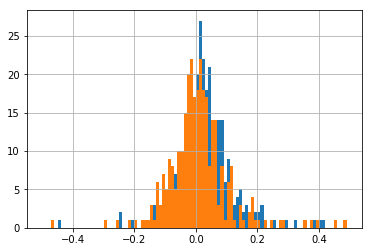

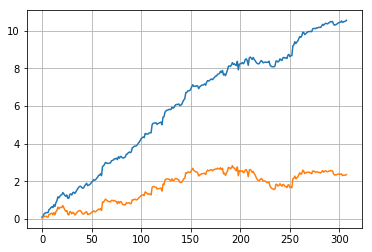

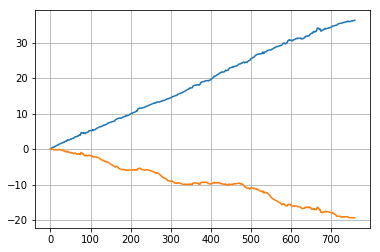

In [212]:
import matplotlib.pyplot as plt

plt.figure(0)
bins = [i/100 for i in range(-50,50)]
histG = plt.hist(positions[pos_under_2p]['GROI'], bins=bins)
histR = plt.hist(positions[pos_under_2p]['ROI'], bins=bins)
plt.grid()

pos_under_thr = positions[pos_under_2p]
#pos_under_thr.index = range(pos_under_thr.shape[0])
plt.figure(1)
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['GROI'].cumsum())
plt.plot(range(pos_under_thr.shape[0]),pos_under_thr['ROI'].cumsum())
plt.grid()

plt.figure(2)
#print(pos_under_thr['ROI'])
print(positions[pos_under_2p]['GROI'].shape)
cumG = plt.plot(positions['GROI'].cumsum())#, bins=bins
cumR = plt.plot(positions['ROI'].cumsum())
plt.grid()

Di
11   -0.1238
12   -0.0484
13    0.7162
14   -0.0283
15   -0.1758
16   -0.0304
17   -0.0886
18    0.1331
19    0.3527
20   -0.1181
21    0.6812
22    0.2556
23    0.6136
24   -0.0638
25   -0.1430
26    0.3539
27   -0.3579
28    0.7094
31   -0.1142
32    0.1715
33    0.2438
34   -0.2778
35   -0.2746
36   -0.7419
37   -0.0909
38    0.3210
39   -0.1950
40    0.2973
41   -0.1490
42    0.6102
43   -0.1534
44    0.2523
45   -0.1757
Name: ROI, dtype: float64
Di
11   -0.0823
12    0.1746
13    0.9831
14   -0.0061
15    0.1361
16    0.0704
17    0.0415
18    0.2259
19    0.5111
20    0.2032
21    0.9120
22    0.5060
23    1.0582
24    0.0520
25    0.2226
26    0.7339
27   -0.1593
28    0.9302
31    0.0127
32    0.3338
33    0.4859
34   -0.0826
35   -0.0562
36   -0.2759
37    0.2914
38    0.6153
39    0.0268
40    0.6934
41    0.3318
42    1.0443
43    0.0097
44    0.4846
45    0.1329
Name: GROI, dtype: float64
Di
11     1
12     6
13     8
14     1
15     8
16     4
17     4
18     4
19     5

(array([ 6., 14.,  6.,  6.]),
 array([ 0,  5, 10, 15, 20]),
 <a list of 4 Patch objects>)

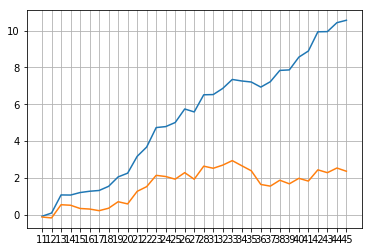

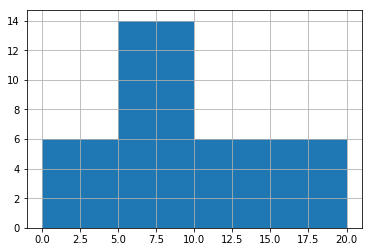

In [214]:
#positions
#grouped = pos_format.groupby(['asset'])
weekly_group = positions[pos_under_2p].groupby([pd.to_datetime(positions[pos_under_2p]['Di']).dt.strftime('%W')])['ROI']
weekly_group_G = positions[pos_under_2p].groupby([pd.to_datetime(positions[pos_under_2p]['Di']).dt.strftime('%W')])['GROI']
weekly_sum = weekly_group.sum()
weekly_sum_G = weekly_group_G.sum()
weekly_count = weekly_group.count()
#weekly_sum.cumsum()
plt.figure(0)
plt.plot(weekly_sum_G.cumsum())
plt.plot(weekly_sum.cumsum())
plt.grid()
print(weekly_sum)
print(positions[pos_under_2p].groupby([pd.to_datetime(positions[pos_under_2p]['Di']).dt.strftime('%W')])['GROI'].sum())
print(weekly_count)
plt.figure(1)
plt.grid()
plt.hist(weekly_count, bins=range(0,max(weekly_count),5))

#for name, group in weekly_group:
#    print(name)
#    print(group.to_string())
#pd.to_datetime(positions['Di']).dt.strftime('%W')
#pd.to_datetime(positions['Di'])#.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

In [212]:
positions[positions['ROI']<-.2]['ROI'].sum()

-5.5287999999999995

In [91]:
positions['GROI'].min()

-0.5216

0.035496947809999325


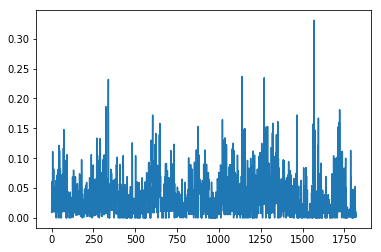

In [144]:
abs_B = (positions['Bo']-positions['Ao'])
abs_A = (positions['Bi']-positions['Ai'])
dif = 100*abs(abs_A-abs_B)/positions['Ai']
print(np.mean(dif))
plt.plot(dif)